# Bayesian Lasso regression

Last section we developed the theory for Bayesian regression. Here we *extend* the model using another regularizing prior using the Laplace distribution. Since the posterior has no analytical form, we need to approximate it, for instance using sampling. Il'' edmonstrate the Bayesian Lasso using `rstan` and `greta`.

**As usual I do not take warranty for the correctness or completeness of this document.**

In [2]:
options(repr.plot.width=4, repr.plot.height=3)

In [3]:
library(ggplot2)
library(cowplot)
library(rstan)
library(greta)
library(DiagrammeR)
theme_set(theme_cowplot())

source("_util/util.R")



*******************************************************
Note: cowplot does not change the default ggplot2 theme
anymore. To recover the previous behavior, execute:
  theme_set(theme_cowplot())
*******************************************************

Loading required package: StanHeaders
rstan (Version 2.17.3, GitRev: 2e1f913d3ca3)
For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)

Attaching package: ‘greta’

The following objects are masked from ‘package:stats’:

    binomial, poisson

The following objects are masked from ‘package:base’:

    %*%, backsolve, beta, colMeans, colSums, diag, forwardsolve, gamma,
    rowMeans, rowSums, sweep



In [4]:
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())

In classical LASSO regression we put an $\ell_1$ penalty on the coefficients of the linear model, such that we try to optimize the following objective:

\begin{align}
\arg\min_{\theta} - \mathcal{L}(\boldsymbol \beta) + || \boldsymbol \beta ||_1,
\end{align}

where $\mathcal{L}(\theta)$ is the likelihood and $\boldsymbol \beta$ the model parameters. In a fully Bayesian setting this can be interpreted as conditional independent Laplace priors on $\boldsymbol \beta$:

\begin{align}
p(\boldsymbol \beta \mid \sigma^2) =\prod_i^p \frac{\lambda}{2\sqrt{\sigma^2}} \exp \left( -\lambda \frac{|\beta_i|}{\sqrt{\sigma^2}}  \right)
\end{align}

Our model will then have the following hierarchical form (where we use the compound normal-exponential distribution (see the `Stan` reference)):

\begin{align}
 \boldsymbol \beta \mid \sigma^2,\tau_1^2, \dots, \tau_p^2 &\sim \mathcal{N}(\mathbf{0}, \sigma^2 \mathbf{D}_{\tau}),\\
 \mathbf{D}_{\tau} &= \text{diag}(\tau_1^2, \dots, \tau_p^2),\\
 \tau_1^2, \dots, \tau_p^2 & \sim \prod_1^p \text{Exponential}(0.5 \lambda^2),\\
 \sigma^2 &\sim \mathcal{IG}(a, b),\\
\end{align}

where $\lambda$, $a$ and $b$ are hyperparamters. $\lambda$ essentially corresponds to the frequentist LASSO regularization parameter. In a Bayesian setting with would either use an ampirical Bayes approach, use a hyperprior, or -as we will do it here for demonstration- take an educated guess.

Now, that the prior is specified, let's infer the posterior distribution on some data.

In [8]:
set.seed(23)

In [9]:
n <- 1000
beta <- rnorm(1, 1)

X <- matrix(rnorm(n), n)
y <- X %*% beta + rnorm(n, 0, .1)

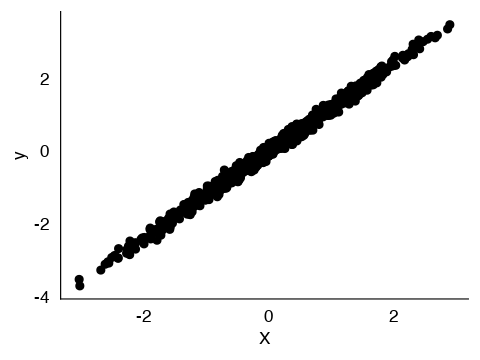

In [10]:
ggplot(data.frame(X=X, y=y)) +
  geom_point(aes(X, y)) +
  simon_theme()

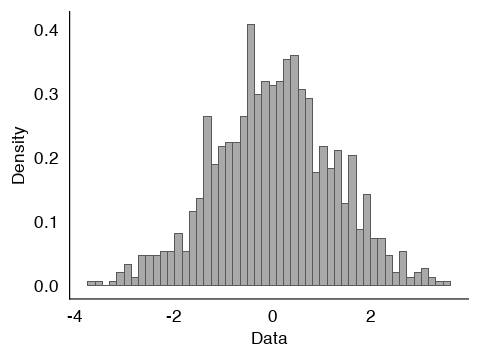

In [11]:
ggplot(data.frame(Y=y)) +
    geom_histogram(aes(Y, y=..density..), fill="darkgrey", color="black", cex=.1, bins=50) +
    simon_theme() +
    scale_y_continuous("Density") +
    scale_x_continuous("Data")

### Inference using Stan

First we will use `Stan`. Stan requires to set up the model.

Then we estimate the posterior of the parameters:

In [12]:
writeLines(readLines("_models/bayesian_lasso_exponential_normal.stan"))

data {
  int<lower=0> N;
  
  vector[N] x;
  vector[N] y;

  real<lower=0> lambda;
}

parameters {
  real beta;
  real sigma;
  real tau;
}

model {
  tau ~ exponential(lambda  * lambda / 2);
  sigma ~ inv_gamma(1, 1);
  beta ~ normal(0, sigma * tau);
  
  y ~ normal(beta * x, sigma);
}


In [14]:
m_norm <- stan(
    "_models/bayesian_lasso_exponential_normal.stan",
    data = list(N = n, x = X[,1], y = y[,1], lambda = 1)
)

In file included from filefc3da6f87bc.cpp:8:
In file included from /Library/Frameworks/R.framework/Versions/3.5/Resources/library/StanHeaders/include/src/stan/model/model_header.hpp:4:
In file included from /Library/Frameworks/R.framework/Versions/3.5/Resources/library/StanHeaders/include/stan/math.hpp:4:
In file included from /Library/Frameworks/R.framework/Versions/3.5/Resources/library/StanHeaders/include/stan/math/rev/mat.hpp:4:
In file included from /Library/Frameworks/R.framework/Versions/3.5/Resources/library/StanHeaders/include/stan/math/rev/core.hpp:14:
In file included from /Library/Frameworks/R.framework/Versions/3.5/Resources/library/StanHeaders/include/stan/math/rev/core/matrix_vari.hpp:4:
In file included from /Library/Frameworks/R.framework/Versions/3.5/Resources/library/StanHeaders/include/stan/math/rev/mat/fun/Eigen_NumTraits.hpp:4:
In file included from /Library/Frameworks/R.framework/Versions/3.5/Resources/library/StanHeaders/include/stan/math/prim/mat/fun/Eigen.hpp:

Warning message:
“There were 2 divergent transitions after warmup. Increasing adapt_delta above 0.8 may help. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”Warning message:
“Examine the pairs() plot to diagnose sampling problems
”

In [15]:
summary(m_norm)$summary

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
beta,1.194855e+00,5.404155e-05,0.003074185,1.188719e+00,1.192815e+00,1.194796e+00,1.1968812,1.2009816,3235.969,0.999443
sigma,9.972532e-02,3.515642e-05,0.002223487,9.533726e-02,9.820789e-02,9.972285e-02,0.1012095,0.1040387,4000.000,1.000307
tau,7.267700e+00,5.858691e-02,2.359239641,3.942835e+00,5.611920e+00,6.863759e+00,8.5276337,12.8199370,1621.597,1.000052
lp__,1.800631e+03,3.218629e-02,1.243921702,1.797442e+03,1.800039e+03,1.800944e+03,1801.5357442,1802.0811410,1493.634,1.001168


ci_level: 0.8 (80% intervals)
outer_level: 0.95 (95% intervals)


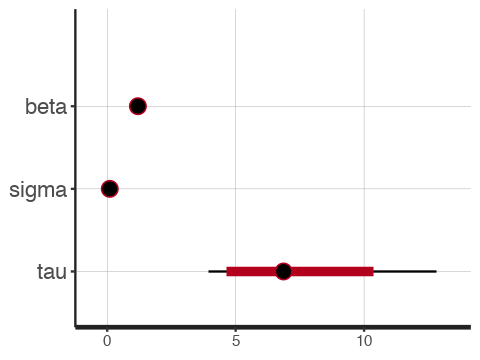

In [16]:
plot(m_norm, pars=c("beta","sigma", "tau"))

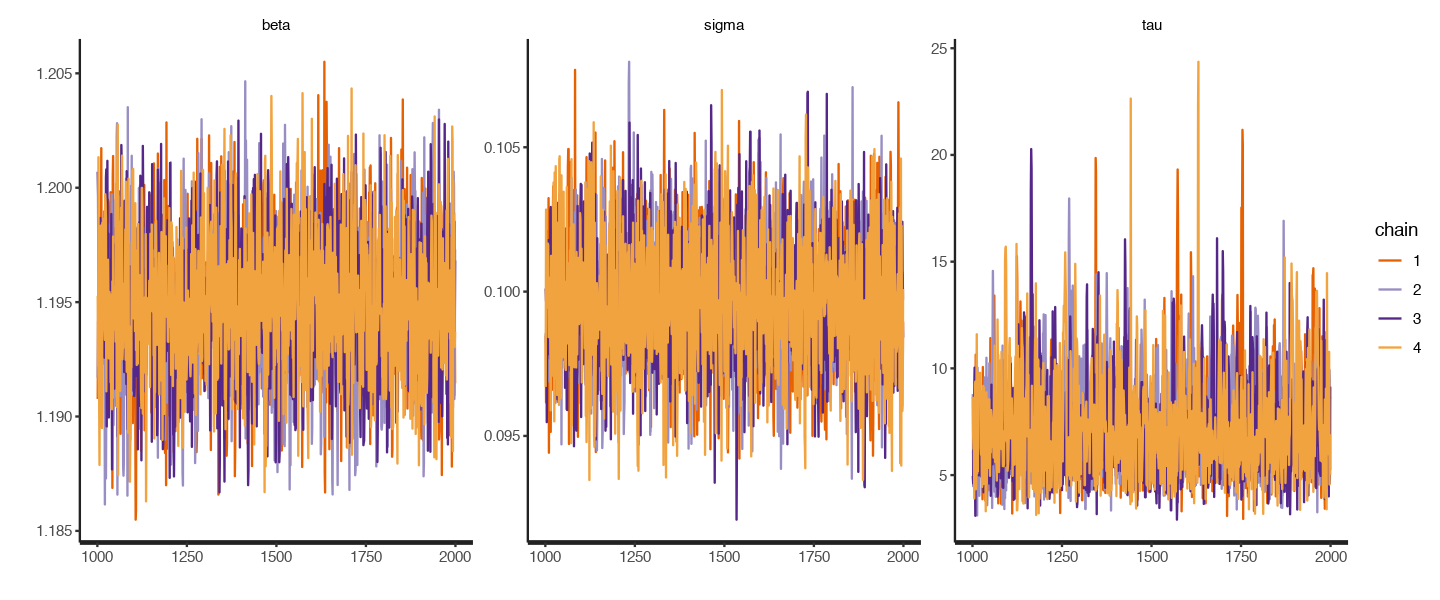

In [17]:
options(repr.plot.width=12, repr.plot.height=5)
traceplot(m_norm)

Stan worked pretty well in infering the true values. Only the posterior interval for `tau` is fairly large. In this case, since the coefficients were identifiable, I guess that `tau` did not play too much of an impact.

Let's quickly check what would happen if we don't formulate the prior like this, but using a Laplace distribution directly. Since we used $\lambda=1$ we don't need to reparametrize.

In [19]:
writeLines(readLines("_models/bayesian_lasso_double_exponential.stan"))

data {
  int<lower=0> N;
  
  vector[N] x;
  vector[N] y;

  real<lower=0> lambda;
}

parameters {
  real beta;
  real sigma;
  real tau;
}

model {
  tau ~ exponential(lambda  * lambda / 2);
  sigma ~ inv_gamma(1, 1);
  beta ~ normal(0, sigma * tau);
  
  y ~ normal(beta * x, sigma);
}


In [18]:
m_norm_lapla <- stan(
    "_models/bayesian_lasso_double_exponential.stan",
    data = list(N = n, x = X[,1], y = y[,1], lambda = 1)
)

Warning message:
“There were 3 divergent transitions after warmup. Increasing adapt_delta above 0.8 may help. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”Warning message:
“Examine the pairs() plot to diagnose sampling problems
”

In [20]:
summary(m_norm_lapla)$summary

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
beta,1.194891e+00,5.246070e-05,0.003051331,1.189117e+00,1.192759e+00,1.194893e+00,1.1969720,1.2009248,3383.0663,0.999816
sigma,9.973071e-02,3.572837e-05,0.002259660,9.527905e-02,9.818733e-02,9.968159e-02,0.1012044,0.1042914,4000.0000,1.001115
tau,7.344901e+00,8.412067e-02,2.451659190,3.933706e+00,5.599282e+00,6.886701e+00,8.6158301,13.0877196,849.4049,1.000918
lp__,1.800600e+03,3.698801e-02,1.295519375,1.797258e+03,1.800022e+03,1.800921e+03,1801.5321985,1802.0695415,1226.7779,1.002200


In [21]:
summary(m_norm)$summary

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
beta,1.194855e+00,5.404155e-05,0.003074185,1.188719e+00,1.192815e+00,1.194796e+00,1.1968812,1.2009816,3235.969,0.999443
sigma,9.972532e-02,3.515642e-05,0.002223487,9.533726e-02,9.820789e-02,9.972285e-02,0.1012095,0.1040387,4000.000,1.000307
tau,7.267700e+00,5.858691e-02,2.359239641,3.942835e+00,5.611920e+00,6.863759e+00,8.5276337,12.8199370,1621.597,1.000052
lp__,1.800631e+03,3.218629e-02,1.243921702,1.797442e+03,1.800039e+03,1.800944e+03,1801.5357442,1802.0811410,1493.634,1.001168


Great :). Same result.

### Inference using Greta

In [22]:
X <- as_data(X)
y <- as_data(y)

In [23]:
lambda <- 1

In [24]:
sigma <- greta::inverse_gamma(1, 1)
tau   <- greta::exponential(lambda  * lambda / 2)
beta  <- greta::normal(0, sigma * tau)

mu <- X %*% beta

In [25]:
distribution(y) =  normal(mu, sigma)

In [26]:
mod <- model(sigma, tau, beta)

In [28]:
draws <- mcmc(mod, n_samples = 1000)
summary(draws)


Iterations = 1:1000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

        Mean SD Naive SE Time-series SE
sigma 0.1046  0        0              0
tau   2.0990  0        0              0
beta  1.1971  0        0              0

2. Quantiles for each variable:

        2.5%    25%    50%    75%  97.5%
sigma 0.1046 0.1046 0.1046 0.1046 0.1046
tau   2.0990 2.0990 2.0990 2.0990 2.0990
beta  1.1971 1.1971 1.1971 1.1971 1.1971


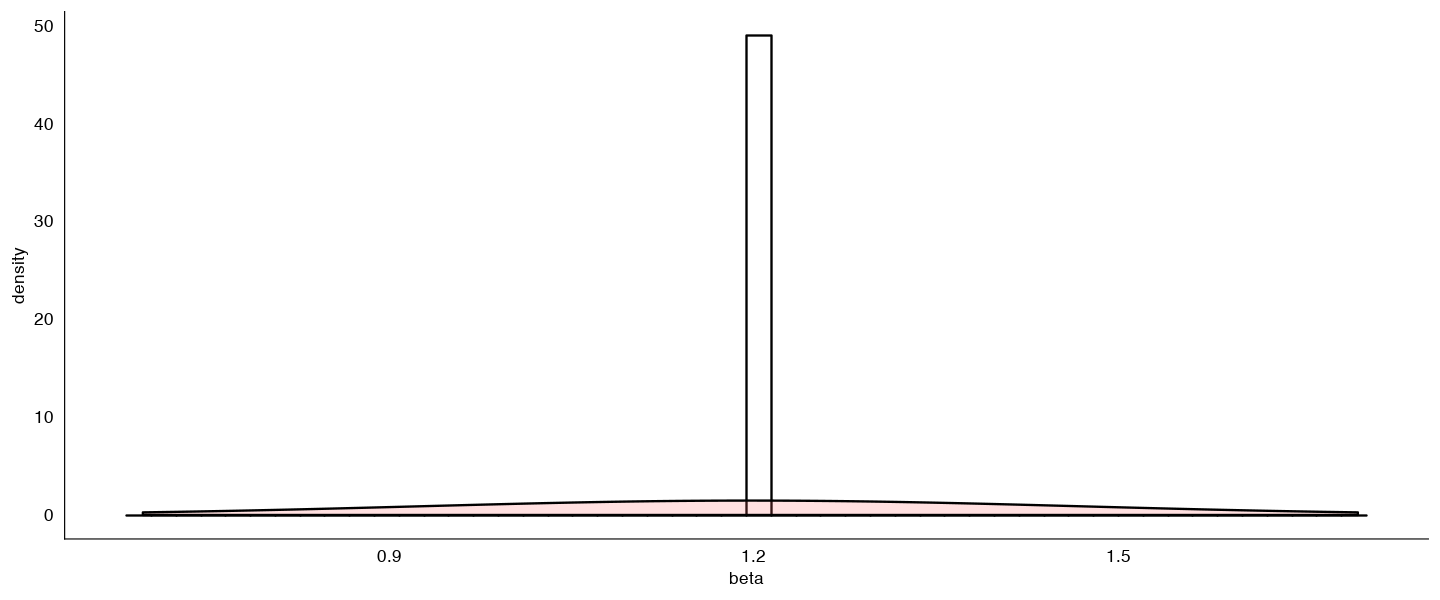

In [29]:
data.frame(draws[[1]]) %>%
  ggplot(aes(x=beta)) + 
  geom_histogram(aes(y=..density..), bins=50, colour="black", fill="white") +
  geom_density(alpha=.2, fill="#FF6666") +
  simon_theme()

In [31]:
mcmc_intervals(draws)

ERROR: Error in mcmc_intervals(draws): could not find function "mcmc_intervals"
